# Loading, reshaping and splitting the data into test/train

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras

# For the model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import EarlyStopping

# Loading models
from keras.models import load_model

# Image preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as kb

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# For decision tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn import tree

# Utilities
import h5py
import itertools

Fix random seed for reproducibility. 

In [84]:
seed = 7
np.random.seed(seed)

In [474]:
emotions = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

In [475]:
X = np.load('./features.npy') # features
y = np.load('./labels.npy') # labels

In [476]:
X = X.reshape(X.shape[0], 48, 48)
X = np.expand_dims(X, axis=4)

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [477]:
y = np_utils.to_categorical(y, num_classes=7)

In [478]:
print(X.shape, y.shape)

(35887, 48, 48, 1) (35887, 7)


In [479]:
X_test = X[28709:]
X_train = X[:28709]
y_test = y[28709:]
y_train = y[:28709]

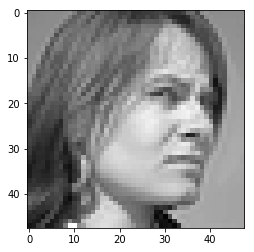

In [480]:
sample = X_train[420].reshape(48, 48)
plt.imshow(sample, interpolation='none', cmap='gray')

## Defining functions to calculated Precision, Recall & F-Scores.

In [130]:
def plot_confusion_matrix(true, prediction, name):
    cm = confusion_matrix(true.argmax(1), prediction.argmax(1))
    cm = cm.astype('float') / cm.sum(axis=1)
    
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title("Emotions")
    plt.colorbar()
    tick_marks = np.arange(7)
    plt.xticks(tick_marks, emotions, rotation=45)
    plt.yticks(tick_marks, emotions)
    
    thresh = cm.max()/1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name + ".jpg", dpi=300)

In [131]:
def get_statistics(true, prediction):
    cm = confusion_matrix(true.argmax(1), prediction.argmax(1))
    TP = np.diag(cm) # True Positive
    FP = np.sum(cm, axis = 0) - TP # False Positive
    FN = np.sum(cm, axis = 1) - TP # False Negatice
    TN = [] # True Negative
    for i in range(7):
        temp = np.delete(cm, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    fscore = 2 * (precision * recall)/(precision + recall)
    return precision, recall, fscore

# Trying out different models

## Decision Tree

In [60]:
features = np.load('./features.npy') # features
labels = np.load('./labels.npy') # labels

In [61]:
features = pd.DataFrame(features)

In [62]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)

In [63]:
classifier = tree.DecisionTreeClassifier(min_samples_split=40)

In [64]:
model = classifier.fit(features_train, labels_train)

In [65]:
prediction = classifier.predict(features_test)

In [66]:
print(accuracy_score(labels_test, prediction))

0.30384508219559764


In [253]:
dt_precision, dt_recall, dt_fscore, _ = precision_recall_fscore_support(labels_test, prediction)

### Accuracy: 30.84%

Can't really tune this more. A neural network would work better.

## Feedforward Neural Network

Note: Requires input in the form of 2304 numbers, not a 48 * 48 matrix like the other neural networks we use.

In [460]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim = 2304))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [461]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 3591      
Total params: 1,446,407
Trainable params: 1,446,407
Non-trainable params: 0
_________________________________________________________________


In [462]:
new_model = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 7s 257us/step - loss: 13.4150 - acc: 0.1675 - val_loss: 13.9671 - val_acc: 0.1335
Epoch 2/10
28709/28709 [==============================] - 3s 92us/step - loss: 13.8735 - acc: 0.1392 - val_loss: 13.9670 - val_acc: 0.1335
Epoch 3/10
28709/28709 [==============================] - 3s 94us/step - loss: 13.8735 - acc: 0.1392 - val_loss: 13.9670 - val_acc: 0.1335
Epoch 4/10
28709/28709 [==============================] - 3s 90us/step - loss: 13.8734 - acc: 0.1392 - val_loss: 13.9670 - val_acc: 0.1335
Epoch 5/10
28709/28709 [==============================] - 3s 91us/step - loss: 13.8734 - acc: 0.1392 - val_loss: 13.9670 - val_acc: 0.1335
Epoch 6/10
28709/28709 [==============================] - 3s 92us/step - loss: 13.8734 - acc: 0.1392 - val_loss: 13.9670 - val_acc: 0.1335
Epoch 7/10
28709/28709 [==============================] - 3s 94us/step - loss: 13.8734 - acc: 0.1392 - val_loss: 13.

In [463]:
scores = model.evaluate(X_test, y_test)

7178/7178 [==============================] - 1s 75us/step


In [464]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  13.346336027163588 %


In [429]:
model.save('feedforward.h5')

In [430]:
model = load_model('feedforward.h5')

In [465]:
y_pred = model.predict(X_test)

### Accuracy: 17.38%

Predicts only 'angry' as an emotion. Not a very good model.

## Convolutional Neural Network

In [279]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [280]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               3965056   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

In [281]:
new_model = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 24s 841us/step - loss: 12.9928 - acc: 0.1930 - val_loss: 12.1326 - val_acc: 0.2473
Epoch 2/10
28709/28709 [==============================] - 19s 659us/step - loss: 12.0839 - acc: 0.2500 - val_loss: 12.1325 - val_acc: 0.2473
Epoch 3/10
28709/28709 [==============================] - 19s 659us/step - loss: 12.0686 - acc: 0.2511 - val_loss: 12.1324 - val_acc: 0.2473
Epoch 4/10
28709/28709 [==============================] - 19s 660us/step - loss: 12.0670 - acc: 0.2512 - val_loss: 12.1324 - val_acc: 0.2473
Epoch 5/10
28709/28709 [==============================] - 19s 664us/step - loss: 12.0798 - acc: 0.2505 - val_loss: 12.1324 - val_acc: 0.2473
Epoch 6/10
28709/28709 [==============================] - 19s 671us/step - loss: 12.0807 - acc: 0.2504 - val_loss: 12.1324 - val_acc: 0.2473
Epoch 7/10
28709/28709 [==============================] - 19s 674us/step - loss: 12.0643 - acc: 0.2513 - 

In [282]:
scores = model.evaluate(X_test, y_test)

7178/7178 [==============================] - 3s 436us/step


In [283]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  24.728336585667446 %


In [284]:
model.save('standard_conv.h5')

In [472]:
model = load_model('standard_conv.h5')

### Accuracy: 24.72%

Predicts only 'happy' as an output. Better than feedforward but not by much.

# Network Selection: CNN

Evidently the CNN shows more promise with a higher initial accuracy. So we proceed to try and fine-tune a modedl.

Creating a standard function to define the CNN.

In [86]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    return model

In [87]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 48, 48)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 46, 46)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 23, 23)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 23, 23)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 23, 23)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 21, 21)       147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 21, 21)       295168    
__________

In [88]:
early_stopping_monitor = EarlyStopping(patience=4)

# Tuning Hyperparameters

Focus is on the optimizer, batch size and number of epochs.

----------

## Optimizer - RMSProp

Batch Size: 96

Epochs: 100

Loss Function: Categorical Cross-Entropy

Model Accuracy: 57.397%

In [25]:
model = create_model()

In [26]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
model.fit(x = X_train, 
          y = y_train, 
          batch_size = 96, 
          epochs = 100,
          callbacks = [early_stopping_monitor],
          validation_data = (X_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 73s 3ms/step - loss: 12.6833 - acc: 0.2309 - val_loss: 13.9875 - val_acc: 0.1335
Epoch 2/100
28709/28709 [==============================] - 65s 2ms/step - loss: 13.7839 - acc: 0.1456 - val_loss: 13.9851 - val_acc: 0.1335
Epoch 3/100
28709/28709 [==============================] - 65s 2ms/step - loss: 13.8871 - acc: 0.1390 - val_loss: 13.3642 - val_acc: 0.1718
Epoch 4/100
28709/28709 [==============================] - 65s 2ms/step - loss: 13.3858 - acc: 0.1701 - val_loss: 13.3541 - val_acc: 0.1719
Epoch 5/100
28709/28709 [==============================] - 65s 2ms/step - loss: 13.7098 - acc: 0.1500 - val_loss: 13.3625 - val_acc: 0.1719
Epoch 6/100
28709/28709 [==============================] - 65s 2ms/step - loss: 13.5879 - acc: 0.1570 - val_loss: 13.3555 - val_acc: 0.1719
Epoch 7/100
28709/28709 [==============================] - 66s 2ms/step - loss: 3.3620 - acc: 0.2554 - val_loss

In [28]:
scores = model.evaluate(X_test, y_test)

7178/7178 [==============================] - 6s 844us/step


In [29]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  57.39760378935637 %


In [31]:
model.save('conv_rms_batch96_epoch100.h5')

--------------

## Optimizer: SGD

Batch Size: 64

Epochs: 10

Loss Function: Categorical Cross-Entropy

Model Accuracy: 55.90%

In [32]:
model = create_model()

In [33]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
model.fit(X_train, y_train, batch_size = 64, epochs = 10)

Epoch 1/10
28709/28709 [==============================] - 66s 2ms/step - loss: 3.9453 - acc: 0.2519
Epoch 2/10
28709/28709 [==============================] - 61s 2ms/step - loss: 3.5790 - acc: 0.3414
Epoch 3/10
28709/28709 [==============================] - 61s 2ms/step - loss: 3.4296 - acc: 0.3950
Epoch 4/10
28709/28709 [==============================] - 61s 2ms/step - loss: 3.2968 - acc: 0.4385
Epoch 5/10
28709/28709 [==============================] - 61s 2ms/step - loss: 3.1786 - acc: 0.4781
Epoch 6/10
28709/28709 [==============================] - 61s 2ms/step - loss: 3.0853 - acc: 0.5005
Epoch 7/10
28709/28709 [==============================] - 61s 2ms/step - loss: 2.9964 - acc: 0.5274
Epoch 8/10
28709/28709 [==============================] - 61s 2ms/step - loss: 2.9226 - acc: 0.5459
Epoch 9/10
28709/28709 [==============================] - 62s 2ms/step - loss: 2.8453 - acc: 0.5617
Epoch 10/10
28709/28709 [==============================] - 63s 2ms/step - loss: 2.7709 - acc: 0.5810

In [36]:
scores = model.evaluate(X_test, y_test)

7178/7178 [==============================] - 6s 834us/step


In [37]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  55.90693786736152 %


In [38]:
model.save('conv_sgd_batch64_epoch10.h5')

--------------

## Optimizer: Adam

Batch Size: 128

Epochs: 20

Learning Rate: 0.0001

Decay: 10e-6

Loss Function: Categorical Cross-Entropy

Model Accuracy: 60.587%

In [79]:
model = create_model()

In [80]:
adam = keras.optimizers.Adam(lr=0.0001, decay=10e-6)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [81]:
model.fit(X_train,
          y_train,
          epochs = 20,
          batch_size = 128,
          validation_data = (X_test, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/20
28709/28709 [==============================] - 68s 2ms/step - loss: 3.9385 - acc: 0.2649 - val_loss: 3.1568 - val_acc: 0.3743
Epoch 2/20
28709/28709 [==============================] - 63s 2ms/step - loss: 2.9912 - acc: 0.3883 - val_loss: 2.7969 - val_acc: 0.4260
Epoch 3/20
28709/28709 [==============================] - 63s 2ms/step - loss: 2.6594 - acc: 0.4528 - val_loss: 2.5021 - val_acc: 0.4767
Epoch 4/20
28709/28709 [==============================] - 63s 2ms/step - loss: 2.3928 - acc: 0.5077 - val_loss: 2.2822 - val_acc: 0.5233
Epoch 5/20
28709/28709 [==============================] - 64s 2ms/step - loss: 2.1870 - acc: 0.5439 - val_loss: 2.1449 - val_acc: 0.5405
Epoch 6/20
28709/28709 [==============================] - 64s 2ms/step - loss: 2.0064 - acc: 0.5817 - val_loss: 2.0188 - val_acc: 0.5624
Epoch 7/20
28709/28709 [==============================] - 63s 2ms/step - loss: 1.8445 - acc: 0.6171 - val_loss: 1.9058 - val_acc:

In [82]:
scores = model.evaluate(X_test, y_test)

7178/7178 [==============================] - 6s 849us/step


In [83]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  60.58790749678475 %


In [84]:
model.save('conv_adam_lr0.0001_batch128_epoch20.h5')

----

## Visualizing the outputs

### Optimizer: RMSProp

In [300]:
model = load_model('conv_rms_batch96_epoch100.h5')

In [301]:
y_pred = model.predict(X_test, verbose=1)

7178/7178 [==============================] - 6s 888us/step


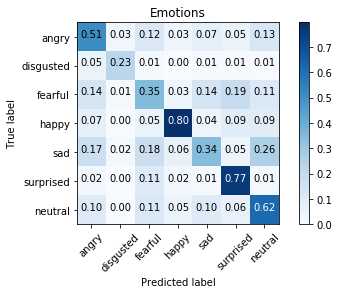

In [302]:
plot_confusion_matrix(y_test, y_pred, "RMSProp")

In [303]:
rms_precision, rms_recall, rms_fscore = get_statistics(y_test, y_pred)

### Optimizer: SGD

In [305]:
model = load_model('conv_sgd_batch64_epoch10.h5')

In [306]:
y_pred = model.predict(X_test, verbose=1)

7178/7178 [==============================] - 6s 883us/step


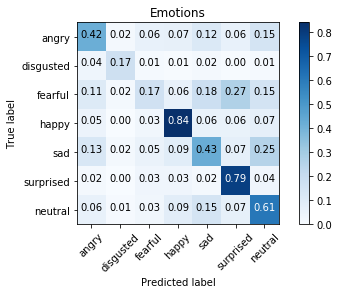

In [307]:
plot_confusion_matrix(y_test, y_pred, "SGD")

In [308]:
sgd_precision, sgd_recall, sgd_fscore = get_statistics(y_test, y_pred)

### Optimizer: Adam

In [565]:
model = load_model('conv_adam_lr0.0001_batch128_epoch20.h5')

In [566]:
y_pred = model.predict(X_test, verbose=1)

7178/7178 [==============================] - 5s 704us/step


In [583]:
model.predict(X_test[0:1], verbose=1)

1/1 [==============================] - 1s 734ms/step


array([[1.1824784e-01, 4.5415580e-02, 5.5959746e-02, 9.5692388e-04,
        4.7816139e-02, 5.3890813e-05, 7.3154992e-01]], dtype=float32)

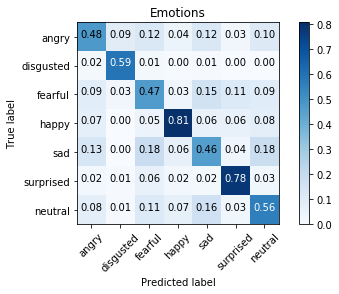

In [311]:
plot_confusion_matrix(y_test, y_pred, "Adam")

In [312]:
adam_precision, adam_recall, adam_fscore = get_statistics(y_test, y_pred)

## Optimizer Selection: Adam

Adam gave the highest overall accuracy. In addition, looking over the Confusion Matrix, we can see that it does drastically better for angry and disgusted faces compared to the other two optimizers. However it is slightly weaker at detecting neutral expressions. It is also marginally lower on detecting a happy face.

## Comparison of the models

In [555]:
def plot_bar(dt, sgd, rms, adam, title=''):
    x = np.arange(7)
    colors = ['red', 'yellow', 'lime', 'blue']
    fig, ax = plt.subplots(figsize=(20, 10))
    r1 = plt.bar(x + 0.0, dt, color = '#D32F2F', width = 0.2)
    r2 = plt.bar(x + 0.2, sgd, color = '#FFA000', width = 0.2)
    r3 = plt.bar(x + 0.4, rms, color = '#303F9F', width = 0.2)
    r4 = plt.bar(x + 0.6, adam, color = '#4CAF50', width = 0.2)

    for rects in [r1, r2, r3, r4]:
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01 * height,
                    '%d' % int(height * 100) + '%',
                    ha='center', va='bottom', fontsize = 12)
    
    plt.xticks(x + 0.3, emotions, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend((r1, r2, r3, r4), ['Decision Tree', 'SGD', 'RMSProp', 'Adam'], prop={'size': 16})
    plt.title(title)
    plt.savefig(title + '.jpg', dpi=300)

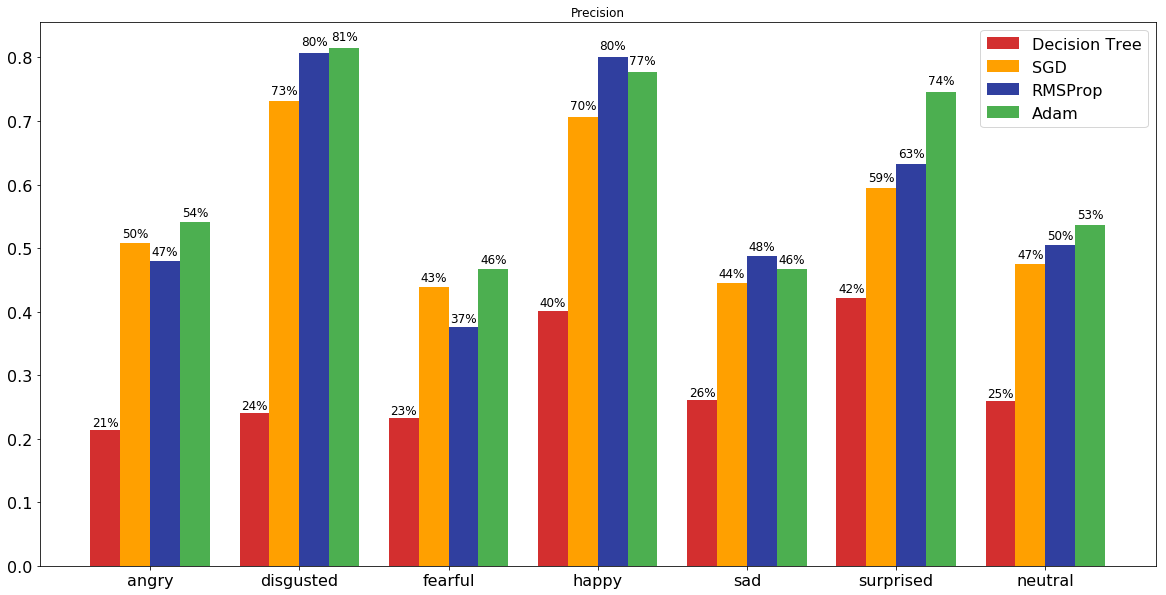

In [556]:
plot_bar(dt_precision, sgd_precision, rms_precision, adam_precision, 'Precision')

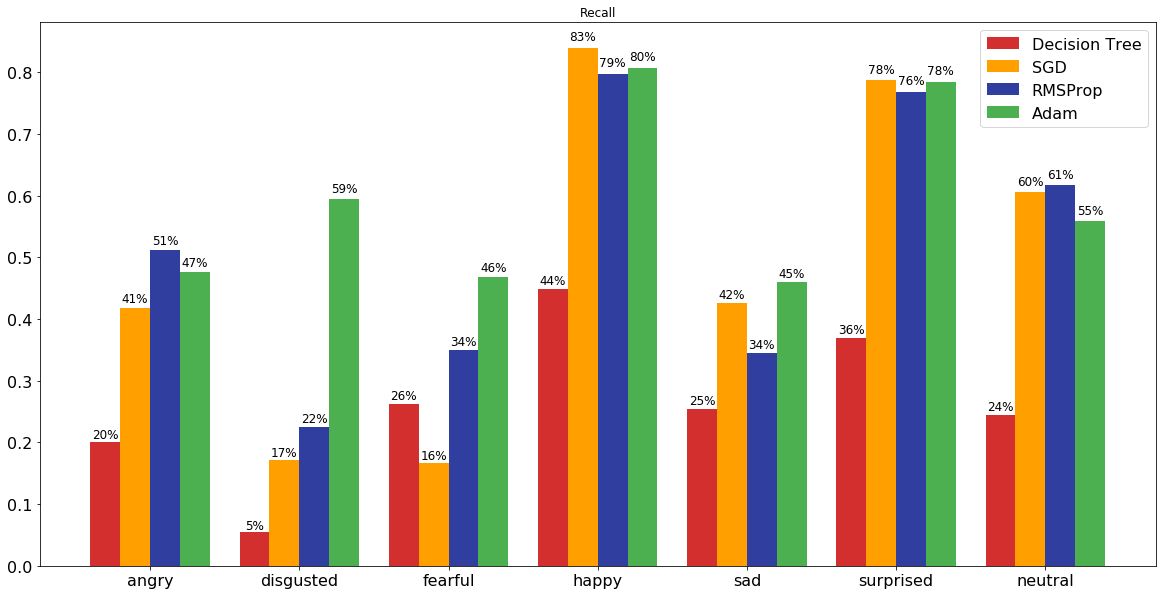

In [557]:
plot_bar(dt_recall, sgd_recall, rms_recall, adam_recall, 'Recall')

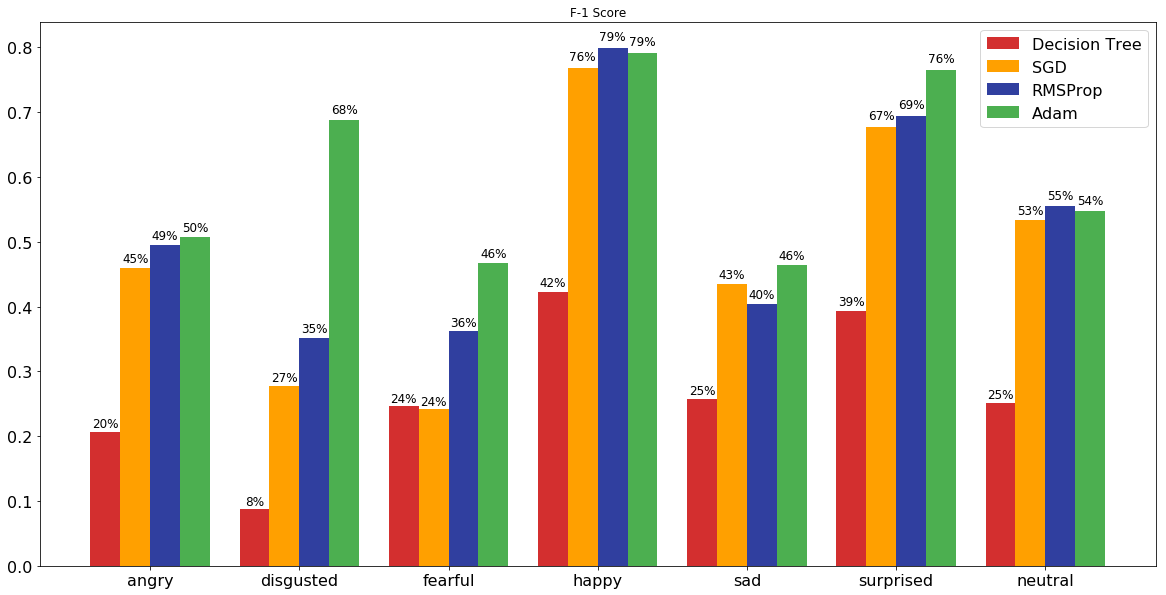

In [558]:
plot_bar(dt_fscore, sgd_fscore, rms_fscore, adam_fscore, 'F-1 Score')